In [13]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#Check that code is running on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [15]:
#Load data
policy=transforms.AutoAugmentPolicy.CIFAR10
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

#Data augmentation
transform = transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(*stats,inplace=True)])

advanced_transform = transforms.Compose(
    [torchvision.transforms.AutoAugment(policy=policy),
     transforms.ToTensor(),
     transforms.Normalize(*stats,inplace=True)])

transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(*stats,inplace=True)])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=advanced_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale',
#            'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
#            'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
#            'bottles', 'bowls', 'cans', 'cups', 'plates',
#            'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
#            'clock', 'computer' 'keyboard', 'lamp', 'telephone', 'television',
#            'bed', 'chair', 'couch', 'table', 'wardrobe',
#            'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
#            'bear', 'leopard', 'lion', 'tiger', 'wolf',
#            'bridge', 'castle', 'house', 'road', 'skyscraper',
#            'cloud', 'forest', 'mountain', 'plain', 'sea',
#            'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
#            'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
#            'crab', 'lobster', 'snail', 'spider', 'worm',
#            'baby', 'boy', 'girl', 'man', 'woman',
#            'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
#            'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
#            'maple', 'oak', 'palm', 'pine', 'willow',
#            'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
#            'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


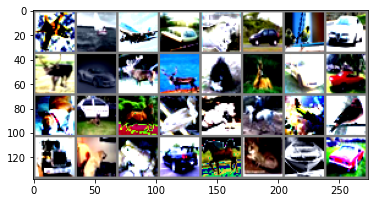

plane ship  plane car   horse car   bird  car   deer  car   deer  deer  dog   deer  car   car   dog   car   horse bird  horse horse plane bird  truck dog   frog  car   horse cat   ship  car  


In [16]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show some images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def conv_block(in_channels, out_channels, pool=False, dropout=False, dropout_and_batch_norm=False):
    if dropout:
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.Dropout(p=0.2), 
              nn.ReLU(inplace=True)]
    elif dropout_and_batch_norm:
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.Dropout(p=0.2),
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    else:
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, scheduler="StepLR", momentum=True):
    torch.cuda.empty_cache()
    history = []
    
    #Set up optimizer
    if momentum:
        optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay, momentum=0.9)
    else:
        optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    #Set up schedulers
    if scheduler == "StepLR":
        sched = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.9)
    elif scheduler == "CosineLR":
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3)
    elif scheduler == "CosineWarm":
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)
    elif scheduler == "OneCycle":
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                 steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            #Clip gradients
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            #Learning rate update
            lrs.append(get_lr(optimizer))
            sched.step()
        
        #Validate
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [21]:
device
model = to_device(ResNet(3, 10), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [22]:
train_ds=trainset
valid_ds=testset
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [23]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_funcs = [torch.optim.SGD, torch.optim.Adam]
schedulers = ["StepLR", "CosineLR", "CosineWarm", "OneCycle"]

In [24]:
history = []

for opt_func in opt_funcs:
    for scheduler in schedulers:
        history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                    #grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func, scheduler=scheduler)

KeyboardInterrupt: 